# Функциональный анализ RNA-Seq

Деконволюция экспрессии опухоли из bulk RNA-seq является сложной задачей, так как bulk RNA-seq не предоставляет информацию о профиле экспрессии отдельных клеток, из которых состоит опухоль. Вместо этого, bulk RNA-seq представляет собой смесь экспрессии от всех клеток в образце, включая нормальные клетки, иммунные клетки и опухолевые клетки.

Несмотря на это, существует несколько подходов, которые могут помочь в деконволюции профиля экспрессии опухоли из bulk RNA-seq. Один из таких подходов - использование методов деконволюции экспрессии на основе машинного обучения. Эти методы основаны на построении моделей машинного обучения, которые могут предсказывать относительную долю каждого типа клеток в смеси на основе генной экспрессии.

Некоторые инструменты, которые могут помочь в решении этой задачи, включают CIBERSORT, xCell и MCP-counter. Эти инструменты используют различные алгоритмы машинного обучения, чтобы деконволюировать профиль экспрессии опухоли из bulk RNA-seq, учитывая различные типы клеток, которые могут присутствовать в образце.

Однако, необходимо понимать, что результаты деконволюции экспрессии опухоли из bulk RNA-seq могут быть ограничены и некоторые аспекты профиля экспрессии могут быть упущены. Также необходимо учитывать, что точность и надежность таких инструментов может зависеть от конкретного типа опухоли, используемых данных и настроек инструмента.

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [1]:
# !pip3 install gseapy==0.10.8
# !wget https://raw.githubusercontent.com/BostonGene/MFP/master/gene_signatures.gmt

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

**ssGSEA**

Мы начнём с того, что оценим выраженность различных сигнатур на выборке из 40 пациентов из TCGA с мелкоклеточным раком лёгкого (аденокарциномой). Сначала прочитаем сами экспрессии (TPM'ы) и сигнатуры.

In [3]:
# check if its really tpms!!!
normal_blood_expr = pd.read_csv('Normal-blood-expr.tsv', sep='\t', index_col=0)
luad_expr = pd.read_csv('LUAD-expr.tsv', sep='\t', index_col=0)

In [4]:
signatures = {}

with open("gene_signatures.gmt") as f:
  for line in f.readlines():
    signatures[line.split("\t")[0]] = line.strip().split("\t")[2:]

А теперь запустим GSEApy и оценим выраженность сигнатур в этих образцах. Для примера мы взяли сигнатуры из статьи, в которой охарактеризовывают опухоли по выраженности экспрессионных иммуного микроокружения сигнатур в них.

Он используется для определения значимости биологических процессов и путей в экспрессионных данных, основываясь на априорном знании об этих процессах и путях.

https://www.cell.com/cancer-cell/fulltext/S1535-6108(21)00222-1

In [5]:
import gseapy as gp

ss = gp.ssgsea(
    data=luad_expr,
    gene_sets=signatures.copy(),
    outdir=None,
    min_size=3,
    sample_norm_method="rank",
    no_plot=True
)
ssGSEA = ss.res2d

/home/iuliiasolomennikova/miniconda3/lib/python3.9/site-packages/gseapy/gsea.py:726: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, ser in df.iteritems():


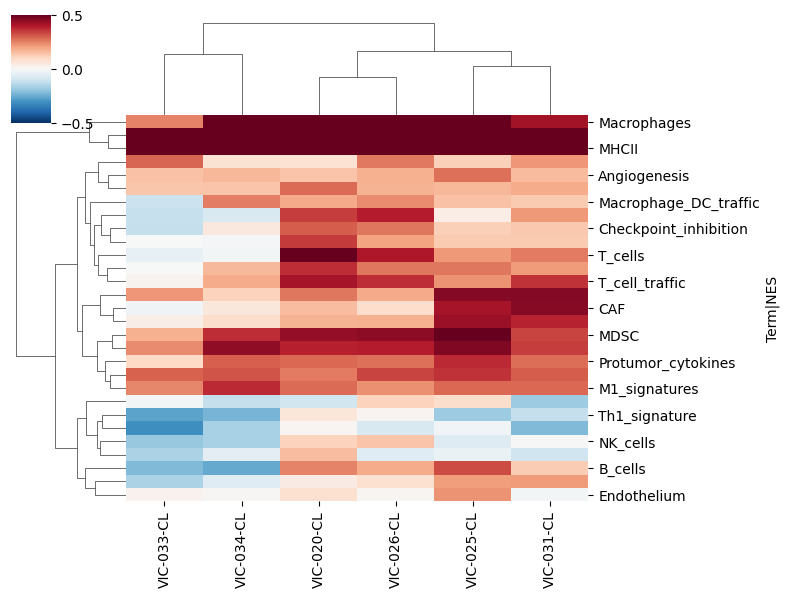

In [40]:
sns.clustermap(ssGSEA, cmap="RdBu_r", vmin=-0.5, vmax=0.5, figsize=(8, 6), method="average");

In [6]:
ss_blood = gp.ssgsea(
    data=normal_blood_expr,
    gene_sets=signatures.copy(),
    outdir=None,
    min_size=3,
    sample_norm_method="rank",
    no_plot=True
)
ssGSEA_blood = ss_blood.res2d

/home/iuliiasolomennikova/miniconda3/lib/python3.9/site-packages/gseapy/gsea.py:726: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, ser in df.iteritems():


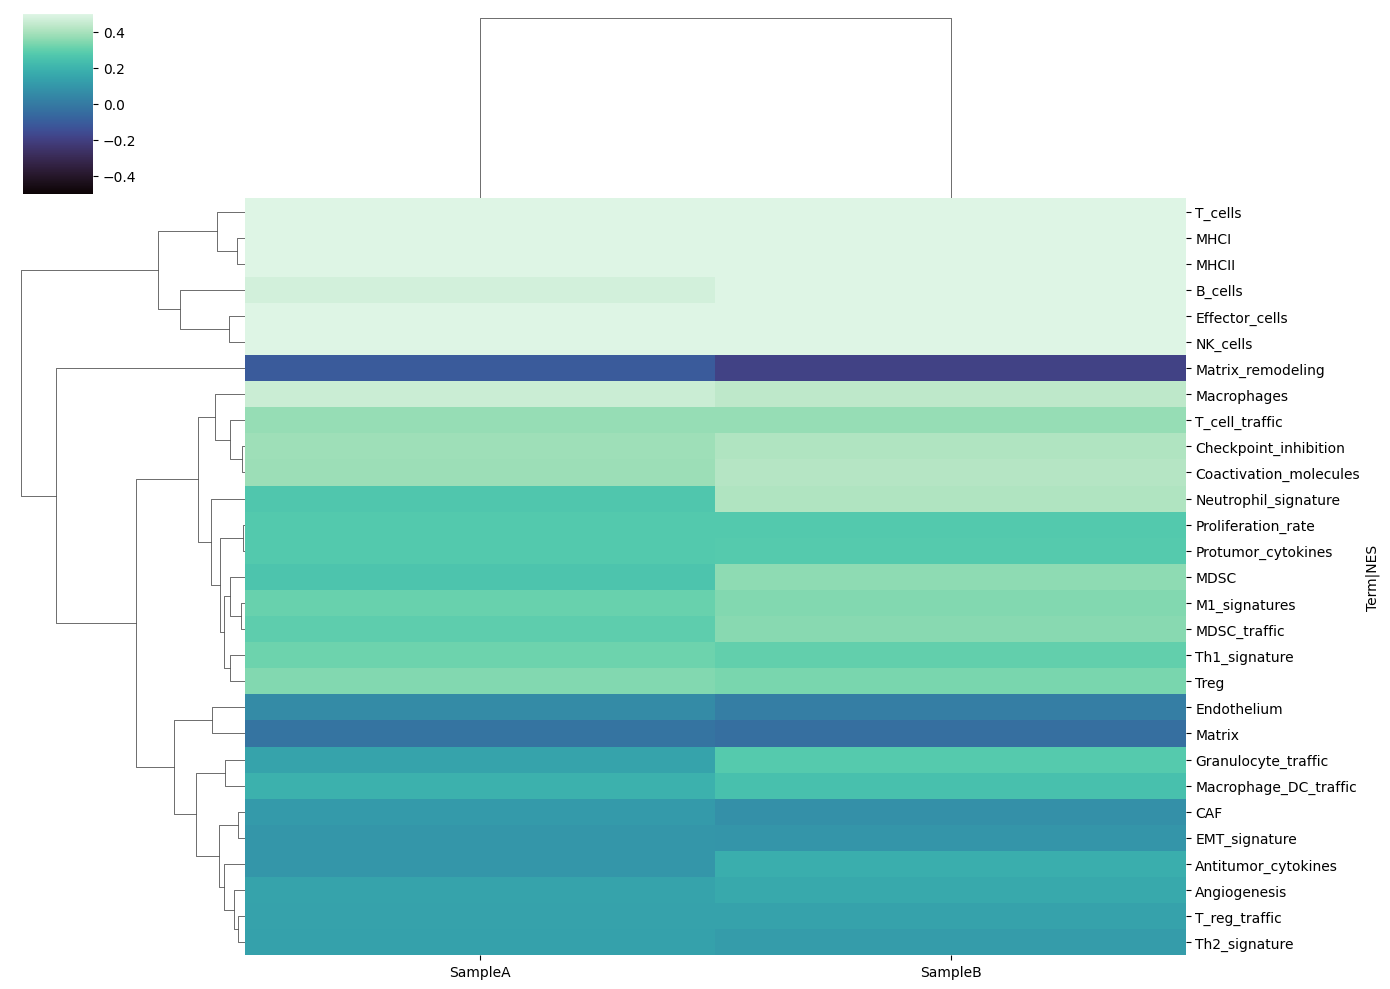

In [12]:
sns.clustermap(ssGSEA_blood, cmap="mako", vmin=-0.5, vmax=0.5, figsize=(14, 10), method="average");

 Видно, что образцы, которые мы анализируем, делятся на две группы в зависимости от выраженности экспрессионных сигнатур, и мы бы объяснить, почему они делятся именно на эти две группы.

**GSEA**

Теперь выполним стандартный GSEA с теми же генными наборами, что мы использовали в прошлый раз, и с кластерами, которые мы получили из ssGSEA. Сначала возьмём кластера, которые у нас получились на прошлом шаге.

In [7]:
from scipy.spatial import distance
from scipy.cluster import hierarchy

labels = ["low_immune" if i == 1 else "immune" for i in hierarchy.fcluster(
  hierarchy.linkage(distance.pdist(ssGSEA.T), method="average"),
  t=2,
  criterion="maxclust"
)]

In [8]:
gs_res_luad = gp.gsea(
    data=luad_expr,
    gene_sets=signatures.copy(),
    cls=labels,
    min_size=3,
    permutation_type="phenotype",
    permutation_num=1000,
    outdir=None,
    method="signal_to_noise"
)

/home/iuliiasolomennikova/miniconda3/lib/python3.9/site-packages/gseapy/gsea.py:391: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_std =  df.groupby(by=cls_dict, axis=1).std()
/home/iuliiasolomennikova/miniconda3/lib/python3.9/site-packages/gseapy/algorithm.py:316: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_std =  df.groupby(by=classes, axis=1).std()


Посмотрим, какие сигнатуры наиболее значимо различают наши группы, и отрисуем GSEA plot для одного значимого и одного не значимого случая.

In [9]:
gs_res_luad.res2d.head()

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Treg,0.799985,1.713583,0.102041,0.114487,7,7,TNFRSF18;FOXP3;CCR8;CTLA4;IL10;IKZF2;IKZF4,TNFRSF18;FOXP3;CCR8;CTLA4
NK_cells,0.842910,1.489093,0.141071,0.351312,17,17,CD244;GNLY;KIR2DL4;NCR3;GZMB;IFNG;KLRF1;GZMH;C...,CD244;GNLY;KIR2DL4;NCR3;GZMB;IFNG;KLRF1;GZMH;C...
Coactivation_molecules,0.713975,1.389715,0.105590,0.361815,14,14,CD27;TNFSF4;ICOS;TNFRSF9;CD40LG;CD70;CD28;ICOS...,CD27;TNFSF4;ICOS;TNFRSF9;CD40LG;CD70;CD28;ICOS...
EMT_signature,0.816402,1.509370,0.169059,0.365813,7,7,ZEB1;TWIST1;TWIST2;SNAI2;CDH2;SNAI1;ZEB2,ZEB1;TWIST1;TWIST2;SNAI2;CDH2;SNAI1
Effector_cells,0.907318,1.413304,0.046653,0.369016,12,12,GNLY;FASLG;GZMB;TBX21;IFNG;GZMK;PRF1;GZMA;CD8A...,GNLY;FASLG;GZMB;TBX21;IFNG;GZMK;PRF1;GZMA;CD8A...


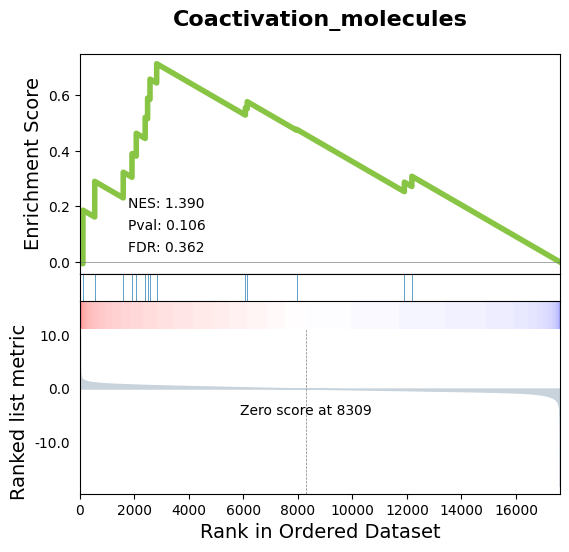

In [14]:
from gseapy import gseaplot, heatmap

group = "Coactivation_molecules"
gseaplot(gs_res_luad.ranking, term=group, **gs_res_luad.results[group])



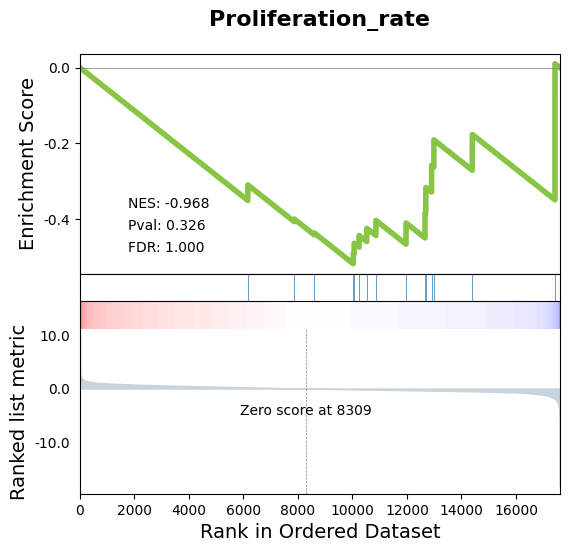

In [29]:
group = "Proliferation_rate"
gseaplot(gs_res_luad.ranking, term=group, **gs_res_luad.results[group])

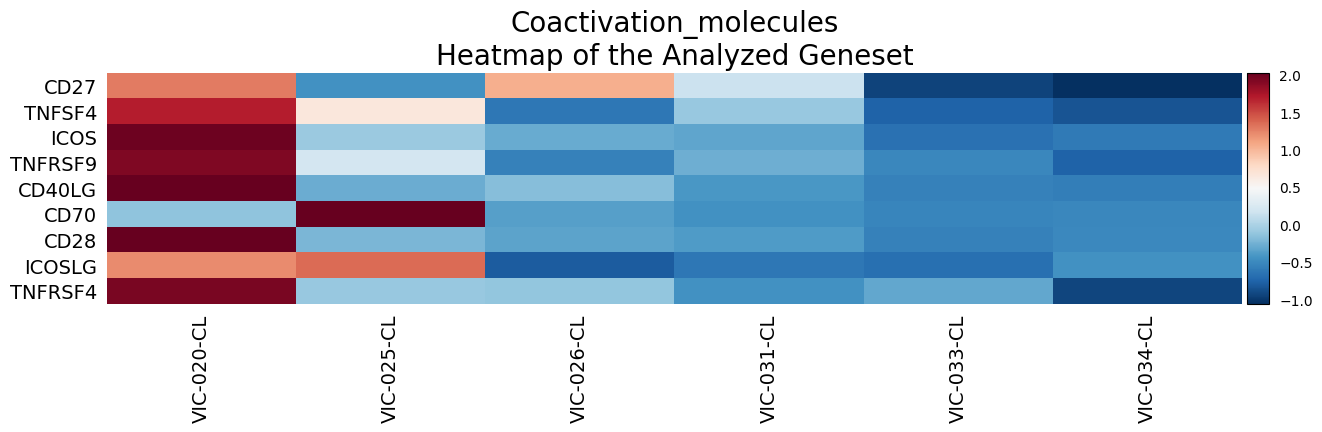

In [27]:
genes = gs_res_luad.res2d.ledge_genes[group].split(";")
heatmap(df=gs_res_luad.heatmat.loc[genes], z_score=0, title=group,
        figsize=(15, 3));